## VQE and Quantum Graph Neural Network in Pennylane

In [153]:
import numpy
import math
import random
import numpy as np
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
import networkx as nx
import pennylane as qml

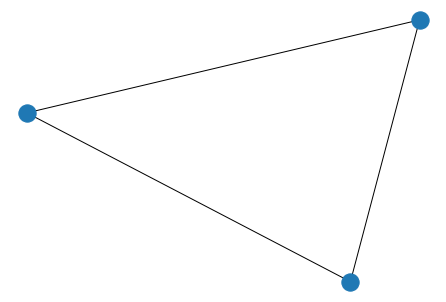

[[5.8, 8.2, 3.2], [2.0, 4.6, 10.0]]


In [155]:
# Initialize the device on which the simulation is run

qubit_number = 3
qubits = range(0, 3)
dev = qml.device("default.qubit", wires=qubit_number)

# Creates the graph structure of the quantum system

ising_graph = nx.Graph()
ising_graph.add_nodes_from(range(0, qubit_number))
ising_graph.add_edges_from([(0, 1), (1, 2), (2, 0)])

nx.draw(ising_graph)
plt.show() 

# Creates parameters

matrix_params = [[random.randint(10, 100)/10 for i in range(0, qubit_number)] for j in range(0, 2)]
print(matrix_params)

In [192]:
# Defines the RZZ gate, in terms of gates in the standard basis set

def RZZ(param, qubit1, qubit2):
    
    qml.CNOT(wires=[qubit1, qubit2])
    qml.RZ(param, wires=qubit2)
    qml.CNOT(wires=[qubit1, qubit2])

# Defines a method that creates an even superposition of basis states

def even_superposition(qubits):
    
    for i in qubits:
        qml.Hadamard(wires=int(i.val))

# Method that prepares the QAOA/time-evolution layer (to be used later)

def qaoa_layer(param1, param2, qubits, ising_graph):
    
    # Applies a layer of coupling gates (based on the graph)
    for count, i in enumerate(ising_graph):
        RZZ(param1[count], int(i[0].val), int(i[1].val))
    
    # Applies a layer of RX gates
    for i in qubits:
        qml.RX(param2[int(i.val)], wires=int(i.val))

# Method that prepares a l0w-energy state        
        
def decoupled_layer(param1, param2, qubits):
    
    # Applies a layer of RZ and RX gates
    for i in qubits:
        qml.RZ(param1[int(i.val)], wires=int(i.val))
        qml.RX(param2[int(i.val)], wires=int(i.val))

# Method that creates the decoupled VQE ansatz

def vqe_circuit(parameters, qubits, depth):
    even_superposition(qubits)
    for i in range(0, int(depth.val)):
        decoupled_layer(parameters[0], parameters[1], qubits)

In [193]:
# Creates the Hamiltonian that we are attempting to learn

def create_hamiltonian_matrix(n, graph):
    
    # Defines Pauli matrices

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))
    
    # Creates the interaction component of the Hamiltonian

    for count, i in enumerate(graph.edges):
        m = 1
        for j in range(0, n):
            if (i[0] == j or i[1] == j):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, matrix_params[0][count]*m)
    
    # Creates the "bias" component of the matrix
    
    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, matrix_params[1][i]*m)

    return matrix

print(create_hamiltonian_matrix(qubit_number, ising_graph))

[[ 17.2  10.    4.6   0.    2.    0.    0.    0. ]
 [ 10.   -5.6   0.    4.6   0.    2.    0.    0. ]
 [  4.6   0.   -0.8  10.    0.    0.    2.    0. ]
 [  0.    4.6  10.  -10.8   0.    0.    0.    2. ]
 [  2.    0.    0.    0.  -10.8  10.    4.6   0. ]
 [  0.    2.    0.    0.   10.   -0.8   0.    4.6]
 [  0.    0.    2.    0.    4.6   0.   -5.6  10. ]
 [  0.    0.    0.    2.    0.    4.6  10.   17.2]]


-20.446759978970313


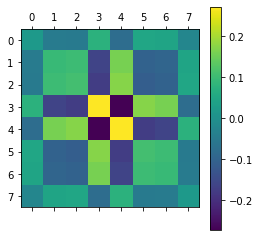

In [194]:
def create_density_matrix(arr):
    
    array = np.array(arr)
    plt.matshow(array)
    plt.colorbar()
    plt.show()

# Finds the eigenvector corresponding to the lowest energy state
    
val, vec = np.linalg.eig(create_hamiltonian_matrix(qubit_number, ising_graph))
m = []

min_ind = list(val).index(min(val))
print(val[min_ind])


for i in range(0, 2**qubit_number):
    m.append(vec[i][min_ind])

create_density_matrix(np.real(np.outer(m, np.conj(m))))

In [225]:
# Defines the circuit that we will use to perform VQE on our Hamiltonian

res_state = 0

def create_circuit(parameters, qubits, depth):
    
    global res_state
    
    vqe_circuit(parameters, qubits, depth)
    res_state = dev._state
    return qml.expval(qml.Hermitian(create_hamiltonian_matrix(qubit_number, ising_graph), wires=range(qubit_number)))

qnode = qml.QNode(create_circuit, dev)

resulting_circuit = qnode([[1, 1, 1], [1, 1, 1]], qubits, 2)
print(resulting_circuit)
print(qnode.draw())

14.740622902180714
 0: ──H──RZ(1)──RX(1)──RZ(1)──RX(1)──╭┤ ⟨H0⟩ 
 1: ──H──RZ(1)──RX(1)──RZ(1)──RX(1)──├┤ ⟨H0⟩ 
 2: ──H──RZ(1)──RX(1)──RZ(1)──RX(1)──╰┤ ⟨H0⟩ 
H0 =
[[ 17.2  10.    4.6   0.    2.    0.    0.    0. ]
 [ 10.   -5.6   0.    4.6   0.    2.    0.    0. ]
 [  4.6   0.   -0.8  10.    0.    0.    2.    0. ]
 [  0.    4.6  10.  -10.8   0.    0.    0.    2. ]
 [  2.    0.    0.    0.  -10.8  10.    4.6   0. ]
 [  0.    2.    0.    0.   10.   -0.8   0.    4.6]
 [  0.    0.    2.    0.    4.6   0.   -5.6  10. ]
 [  0.    0.    0.    2.    0.    4.6  10.   17.2]]



In [226]:
# Creates the cost function

def cost_function(params):
    
    return qnode([params[0:3], params[3:6]], qubits, 2)

# Creates the optimizer for VQE

optimizer = qml.GradientDescentOptimizer(stepsize=1.2)
optimizer2 = qml.AdamOptimizer(stepsize=0.8)

steps = 1000
params = [random.randint(-100, 100)/10 for i in range(0, 6)]

'''
print(cost_function(params))

for i in range(0, steps):
    
    params = optimizer.step(cost_function, params)
    print("Cost Step "+str(i)+": "+str(num_cost_function(params)))

print(params)
'''

out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':steps})
g = out['x']
print(out)

     fun: -19.23664265267429
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 113
  status: 1
 success: True
       x: array([-7.32691811,  4.91828893, -4.83467972,  5.44024923,  6.8744268 ,
        5.81259681])


 0: ──H──RZ(-7.327)──RX(5.44)───RZ(-7.327)──RX(5.44)───╭┤ ⟨H0⟩ 
 1: ──H──RZ(4.918)───RX(6.874)──RZ(4.918)───RX(6.874)──├┤ ⟨H0⟩ 
 2: ──H──RZ(-4.835)──RX(5.813)──RZ(-4.835)──RX(5.813)──╰┤ ⟨H0⟩ 
H0 =
[[ 17.2  10.    4.6   0.    2.    0.    0.    0. ]
 [ 10.   -5.6   0.    4.6   0.    2.    0.    0. ]
 [  4.6   0.   -0.8  10.    0.    0.    2.    0. ]
 [  0.    4.6  10.  -10.8   0.    0.    0.    2. ]
 [  2.    0.    0.    0.  -10.8  10.    4.6   0. ]
 [  0.    2.    0.    0.   10.   -0.8   0.    4.6]
 [  0.    0.    2.    0.    4.6   0.   -5.6  10. ]
 [  0.    0.    0.    2.    0.    4.6  10.   17.2]]

[-0.26791495-0.70934334j -0.22897693-0.60639634j -0.005698  -0.01515495j
  0.00738261+0.01959608j  0.00423678+0.01109661j  0.00034463+0.00090279j
  0.02228341+0.05894364j -0.00338353-0.00903503j]


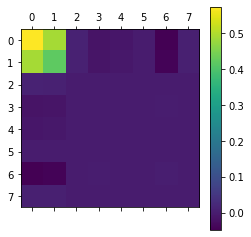

In [227]:
# Runs the circuit for the case of the optimal parameters

res = [g[0:3], g[3:6]]
qnode(res, qubits, 2)
print(qnode.draw())
vqe_state = res_state
print(vqe_state)
create_density_matrix(np.real(np.outer(vqe_state, np.conj(vqe_state))))

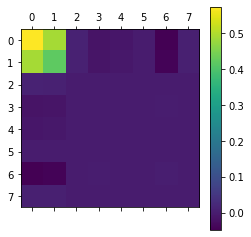

In [228]:
hbar = 1

# Creates the numrical simulation, to test our time-evolution circuit

def time_evolution_test(time, vec):
    
    new_matrix = scipy.linalg.expm(complex(0,-1)*create_hamiltonian_matrix(qubit_number, ising_graph)*time / hbar)
    return np.matmul(new_matrix, vec)

vec = time_evolution_test(0, vqe_state)
create_density_matrix(np.real(np.outer(vec, np.conj(vec))))

#print("Fidelity: "+str(np.inner(np.conj(vec), vector)*np.inner(np.conj(vector), vec)))

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


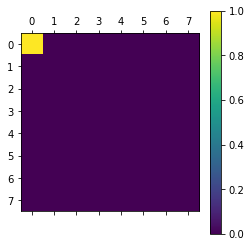

In [231]:
# Creates the Trotterized time-evolution circuit

dev2 = qml.device("default.qubit", wires=qubit_number)
final_state = 0

def state_evolve(qubits, params, vqe_depth, time, depth, edges):
    
    vqe_circuit(params, qubits, vqe_depth)
    for j in range(0, int(depth.val)):
        qaoa_layer([i*time.val/depth.val for i in matrix_params[0]], [i*time.val/depth.val for i in matrix_params[1]], qubits, edges)

def node_se(qubits, params, vqe_depth, time, depth, edges):
    
    global final_state
    
    state_evolve(qubits, params, vqe_depth, time, depth, edges)
    final_state = dev2._state
    print(final_state)
    return qml.expval(qml.PauliZ(1))

time_qnode = qml.QNode(node_se, dev2)
edges = [i for i in ising_graph.edges]
time_qnode(qubits, res, 2, 0, 1, edges)
print(final_state)
create_density_matrix(np.real(np.outer(final_state, np.conj(final_state))))